<a href="https://colab.research.google.com/github/ArshadJafri/LLM_Centaur/blob/main/minitaur_finetune_stroopTask_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This is to save this colabnotebook and its model from losing all the memory when its runtime gets expired..
#So we first mount to google drive.

from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/MyDrive/minitaur_model_checkpoint"

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
trainer.save_model(output_dir)  # saves model, tokenizer, and optimizer state

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'trainer' is not defined

In [3]:
#This cell has code to load all of the previously saved data again to this notebook.

from google.colab import drive
drive.mount('/content/drive')

from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer

checkpoint_dir = "/content/drive/MyDrive/minitaur_model_checkpoint"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
model = AutoModelForCausalLM.from_pretrained(checkpoint_dir)

# If using Trainer, resume training
# But first, recreating trainer is important, otherwise, it will throw an error:
trainer.train(resume_from_checkpoint=checkpoint_dir)

Mounted at /content/drive


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'trainer' is not defined

In [1]:
!pip install "unsloth[colab-new]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
from unsloth import FastLanguageModel
import transformers

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
import json
from sklearn.model_selection import train_test_split

# Path to your prepared JSONL
jsonl_path = "/content/sample_data/final_row_prompt.jsonl"
# Read all lines
with open(jsonl_path, 'r') as f:
    lines = f.readlines()

# Split
train_lines, val_lines = train_test_split(lines, test_size=0.2, random_state=42)

# Save splits
with open("train_100.jsonl", 'w') as f:
    f.writelines(train_lines)

with open("val_100.jsonl", 'w') as f:
    f.writelines(val_lines)

In [23]:
import json

# Load your JSON file
with open("/content/sample_data/final_row_prompt.json", "r") as f:
    data = json.load(f)  # This expects a list of JSON objects

# Convert to JSONL
with open("/content/sample_data/final_row_prompt.jsonl", "w") as f:
    for record in data:
        f.write(json.dumps(record) + "\n")

print("Converted JSON → JSONL: output.jsonl")

Converted JSON → JSONL: output.jsonl


In [8]:
print(model.hf_device_map)


NameError: name 'model' is not defined

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "marcelbinz/Llama-3.1-Minitaur-8B"   # update if your exact HF id differs


# 4-bit quantization config (QLoRA defaults)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,  # A100 supports bfloat16
    llm_int8_enable_fp32_cpu_offload=True # Enable CPU offloading for 32-bit modules
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Define a custom device map to handle potential offloading
device_map = {"": 0} # Try to put most layers on GPU 0

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map, # Use the custom device map
    trust_remote_code=True,  # in case the repo defines custom modeling
)
model.config.use_cache = False  # important with gradient checkpointing

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

In [5]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare the quantized model for k-bit training
model = prepare_model_for_kbit_training(model)

# A solid LoRA config for small instruction-style datasets (~4k samples)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


In [6]:
from datasets import load_dataset

data_files = {"train": "train_100.jsonl", "validation": "val_100.jsonl"}
raw_ds = load_dataset("json", data_files=data_files)

# Quick peek
print(raw_ds)
print(raw_ds["train"][0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 22000
    })
    validation: Dataset({
        features: ['Age', 'Gender', 'PTSD_Level', 'PreviousDiagnosis_List', 'PreviousDiagnosis_Other', 'event_description', 'event_rating', 'participantid_num'],
        num_rows: 5500
    })
})
{'Age': 49, 'Gender': 'Female', 'PTSD_Level': 'High PTSD', 'PreviousDiagnosis_List': 'Posttraumatic Stress Disorder', 'PreviousDiagnosis_Other': None, 'event_description': 'lost a family member in an earthquake', 'event_rating': 5.0, 'participantid_num': 78}


In [12]:
print(tokenizer.model_max_length)

131072


In [7]:
# updated tokenization code

# --- setup (safe defaults) ---
import os

EOS = tokenizer.eos_token or ""
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

MAX_LEN = 128  # prompt + completion

def build_example(prompt: str, completion: str, debug=False):
    prompt_text = prompt.strip() + "\n\nAnswer:"
    completion_text = " " + str(completion).strip() + EOS

    prompt_ids     = tokenizer(prompt_text, add_special_tokens=False).input_ids
    completion_ids = tokenizer(completion_text, add_special_tokens=False).input_ids

    input_ids = prompt_ids + completion_ids
    labels    = [-100]*len(prompt_ids) + completion_ids
    attn_mask = [1]*len(input_ids)

    # truncate from the left if too long (keeps the "Answer:" + completion)
    if len(input_ids) > MAX_LEN:
        input_ids = input_ids[-MAX_LEN:]
        attn_mask = attn_mask[-MAX_LEN:]
        labels    = labels[-MAX_LEN:]

    # pad to MAX_LEN
    pad_len = MAX_LEN - len(input_ids)
    if pad_len > 0:
        input_ids += [tokenizer.pad_token_id] * pad_len
        attn_mask += [0] * pad_len
        labels    += [-100] * pad_len

    if debug:
        print("\n--- DEBUG EXAMPLE ---")
        print("Prompt text:\n", prompt_text)
        print("Completion text:\n", completion_text)
        print("Decoded (input_ids):\n", tokenizer.decode(input_ids, skip_special_tokens=True))
        print("Decoded (labels):\n", tokenizer.decode([t for t in labels if t != -100], skip_special_tokens=True))

    return {"input_ids": input_ids, "attention_mask": attn_mask, "labels": labels}


def preprocess(batch):
    out = {"input_ids": [], "attention_mask": [], "labels": []}

    # pull straight from your columns
    descs  = batch["event_description"]
    ratings = batch["event_rating"]
    levels  = batch["PTSD_Level"]

    # format completion like: " 4.0 with Medium PTSD"
    # keep one decimal for consistency
    for i, (d, r, lvl) in enumerate(zip(descs, ratings, levels)):
        completion = f"{float(r):.1f} with {lvl} PTSD"
        ex = build_example(d, completion, debug=(i < 1))  # print first sample per batch
        out["input_ids"].append(ex["input_ids"])
        out["attention_mask"].append(ex["attention_mask"])
        out["labels"].append(ex["labels"])

    return out

num_proc = max(os.cpu_count() - 1, 1)

tokenized_ds = raw_ds.map(
    preprocess,
    batched=True,
    remove_columns=raw_ds["train"].column_names,
    num_proc=num_proc,           # <— parallel workers
    load_from_cache_file=True,   # reuse cached results
    desc="Tokenizing",
).with_format("torch")

# map over your HF DatasetDict
#tokenized_ds = raw_ds.map(
 #   preprocess,
 #   batched=True,
 #   remove_columns=raw_ds["train"].column_names,  # drops the original columns
#)

tokenized_ds = tokenized_ds.with_format("torch")


Tokenizing (num_proc=11):   0%|          | 0/22000 [00:00<?, ? examples/s]


--- DEBUG EXAMPLE ---
--- DEBUG EXAMPLE ---


--- DEBUG EXAMPLE ---
--- DEBUG EXAMPLE ---
--- DEBUG EXAMPLE ---Prompt text:

--- DEBUG EXAMPLE ---
 
Prompt text:

--- DEBUG EXAMPLE ---Prompt text:


--- DEBUG EXAMPLE --- Prompt text:
was accused of rape on national TV

Answer:Prompt text:
walked across a narrow walkway in a ropes course

Answer: 

 


--- DEBUG EXAMPLE ---
lost 15 pounds

Answer:
--- DEBUG EXAMPLE --- Completion text:

--- DEBUG EXAMPLE ---Prompt text:
Completion text:
lost a family member in an earthquake

Answer:Prompt text:
Prompt text:
was hit by a car and broke a vertebrae

Answer: 
 
 
  


 5.0 with High PTSD PTSD<|end_of_text|>Prompt text:
watched a TV show in which a child died in a vehicle accident

Answer:watched a preview for an upcoming blockbuster

Answer:Completion text:
Prompt text:
listened to a radio station

Answer: 2.0 with Low PTSD PTSD<|end_of_text|>Prompt text:
Completion text:
Completion text:

  


 
   Decoded (input_ids):
hosted a dinner par

Tokenizing (num_proc=11):   0%|          | 0/5500 [00:00<?, ? examples/s]


--- DEBUG EXAMPLE ---
--- DEBUG EXAMPLE ---

Prompt text:
Prompt text:
 was disowned from a community

Answer: 
lost a family member in an earthquake

Answer:
--- DEBUG EXAMPLE ---
--- DEBUG EXAMPLE ---
--- DEBUG EXAMPLE ---Completion text:

 
--- DEBUG EXAMPLE --- Completion text:
 2.0 with Low PTSD PTSD<|end_of_text|>

Prompt text:


--- DEBUG EXAMPLE ---
 7.0 with High PTSD PTSD<|end_of_text|>
--- DEBUG EXAMPLE ---
Prompt text:
 Prompt text:
Decoded (input_ids):


--- DEBUG EXAMPLE ---Prompt text:
 
--- DEBUG EXAMPLE ---listened to Beethoven's 5th symphony

Answer: 
 
--- DEBUG EXAMPLE ---
was disowned from a community

Answer: 2.0 with Low PTSD PTSD Decoded (input_ids):

watched a video of a child being shot and killed

Answer:accidentally used a family member's towel

Answer:

Prompt text:
Prompt text:

watched a video of a man being hanged

Answer:Completion text:


 
Prompt text:
Prompt text:
  
Decoded (labels):
Prompt text:
 Completion text:
lost a family member in an earthqu

In [8]:
import torch

# Detect capabilities
has_cuda = torch.cuda.is_available()
cap = torch.cuda.get_device_capability(0) if has_cuda else (0, 0)
is_ampere_plus = has_cuda and cap[0] >= 8  # Ampere (8.x) or newer supports bf16

# Precision flags for Trainer
use_bf16 = is_ampere_plus            # True on A100/Ampere+; False on T4/V100/CPU
use_fp16 = has_cuda and not use_bf16 # True on pre-Ampere CUDA GPUs; False on CPU

print(f"CUDA: {has_cuda}, capability: {cap}, bf16: {use_bf16}, fp16: {use_fp16}")


CUDA: True, capability: (8, 9), bf16: True, fp16: False


In [9]:
#updated training
from transformers import TrainingArguments, Trainer, default_data_collator

# If you only have a 'train' split, make a validation split first
# (Do this once, before tokenization ideally; here’s a safe post-tokenization example)
if "validation" not in tokenized_ds:
    split = tokenized_ds["train"].train_test_split(test_size=0.1, seed=42)
    tokenized_ds = {"train": split["train"], "validation": split["test"]}

EPOCHS = 1
BATCH = 16
GRAD_ACCUM = 2    # effective batch size = 16
LR = 2e-4

args = TrainingArguments(
    output_dir="minitaur-stroop-qlora",
    num_train_epochs=1,
    max_steps = 600,
    per_device_train_batch_size=12,   # increase if VRAM allows
    per_device_eval_batch_size=12,
    gradient_accumulation_steps=1,    # keep effective batch ~ same
    learning_rate=2e-4,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    fp16=use_fp16, bf16=use_bf16,
    gradient_checkpointing=False,     # SPEED (turn off if you can fit)
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.0,
    remove_unused_columns=False,
    report_to="none",
    optim="adamw_torch_fused",         # or "adamw_torch_fused"
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,
)

model.config.use_cache = True   # pair with checkpointing=False

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],  # drop to speed further
    data_collator=default_data_collator,
)


In [10]:
train_result = trainer.train()
trainer.save_model("minitaur-stroop-qlora")  # saves adapter + config

Step,Training Loss
100,0.747800
200,0.166200
300,0.158400
400,0.156500
500,0.149000
600,0.146300


In [ ]:
print(len(steps), steps)
print(len(train_loss), train_loss)

0 []
0 []


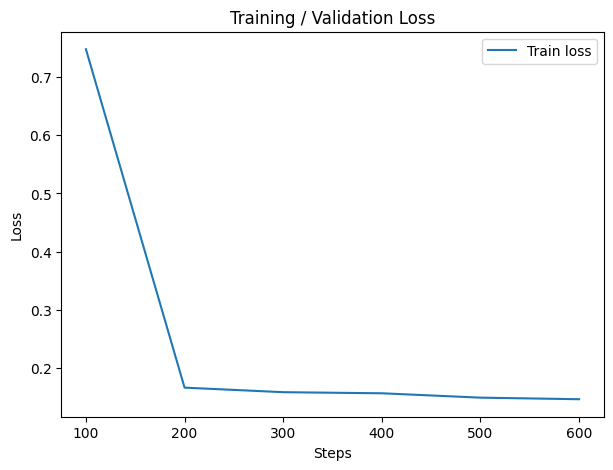

In [12]:
import matplotlib.pyplot as plt

hist = trainer.state.log_history
steps = [h["step"] for h in hist if "loss" in h]
train_loss = [h["loss"] for h in hist if "loss" in h]
eval_steps = [h["step"] for h in hist if "eval_loss" in h]
eval_loss = [h["eval_loss"] for h in hist if "eval_loss" in h]

plt.figure(figsize=(7,5))
plt.plot(steps, train_loss, label="Train loss")
if eval_loss:
    plt.plot(eval_steps, eval_loss, label="Eval loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Generate from the fine-tuned model (LoRA merged at runtime automatically)
def generate(prompt: str, max_new_tokens=32):
    text = prompt.strip() + "\n\nAnswer:"
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            eos_token_id=tokenizer.eos_token_id,
        )
    result = tokenizer.decode(out[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return result.strip()

# Example:
print("\n\n------------------------------------------------------------------------------------------\n\n")
test_prompt = "In the Stroop task, the word 'RED' appears in green ink. What color does the participant choose and what is their reaction time?"
print(generate(test_prompt))



------------------------------------------------------------------------------------------


green; RT=1.133


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/minitaur_model_checkpoint"

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
trainer.save_model(output_dir)  # saves model, tokenizer, and optimizer state

In [ ]:
test_prompts = [
    "In the Stroop task, the word 'BLUE' appears in red ink. What happens?",
    "A participant sees the word 'YELLOW' in yellow ink. What is their response?",
    "What is the Stroop effect in simple terms?"
]

for prompt in test_prompts:
    print("\n------------------------------------------------------------------------------------------\n")
    print(generate(prompt))


------------------------------------------------------------------------------------------

red; red

------------------------------------------------------------------------------------------

green; green=0.671

------------------------------------------------------------------------------------------

green


In [ ]:
test_prompt = "In the Stroop task, the word 'BLUE' appears in blue ink. What color does the participant choose and what is their reaction time?"
print(generate(test_prompt))

blue; RT=0.9
